# DonorsChoose.org Application Screening

## Look at raw data

See what the problem dataset provides, and begin brainstorm for features to exploit/engineer.

In [16]:
import os
import pandas as pd

# Set up directories
data_dir = 'data'
output_dir = 'output'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

res = pd.read_csv(os.path.join(data_dir, 'resources.csv'), dtype='str')
train = pd.read_csv(os.path.join(data_dir, 'train.csv'), dtype='str')
test = pd.read_csv(os.path.join(data_dir, 'test.csv'), dtype='str')

### Resources data

In [17]:
list(res.columns)

['id', 'description', 'quantity', 'price']

In [18]:
res.head(3)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45


Each proposal has a list of items requested. Each proposal may request multiple item types, and multiples of any given item. The quantity requested and price of each item is given. We will want to map the requests to a single proposal, so some summarizing will be necessary. There are many features possible here, it makes sense to anchor the desired features to answerable questions.

- **Do cheap or expensive proposals tend to get approved?**
    - Highest/Lowest price of items (max/min of `price`)
    - Total cost of request (sum of `price` * `quantity` for each proposal)
- **Do proposals with few or many items tend to get approved?**
    - Total number of items requested (sum of `quantity`)
    - Total number of unique items requested (count of items per proposal)
- **Does the type of item requested affect approval?**
    - Aggregation of all words from item descriptions (string join of `description`)

The possibility of information being gleaned from the list of descriptions means that text analysis will need to be used. This was obvious from the data descriptions but here it becomes apparent. 

### Training data

In [19]:
list(train.columns)

['id',
 'teacher_id',
 'teacher_prefix',
 'school_state',
 'project_submitted_datetime',
 'project_grade_category',
 'project_subject_categories',
 'project_subject_subcategories',
 'project_title',
 'project_essay_1',
 'project_essay_2',
 'project_essay_3',
 'project_essay_4',
 'project_resource_summary',
 'teacher_number_of_previously_posted_projects',
 'project_is_approved']

In [20]:
train.head(3)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1


The target variable is contained in `project_is_approved`, with binary classes: rejected=0 and approved=1. 

Looking at the training data it becomes apparent that two approaches should be used to solve this classification problem:

1. **Classification based on categorical features**
1. **Classification based on text information**

The questions and corresponding features that come to mind are:

- **Do the categorical features independently have an affect on approval?**
    - `['teacher_prefix', 'school_state', 'project_grade_category', 'project_subject_categories', 'project_subject_subcategories']`
    - Acceptance rate of each feature
    - Number of submissions of each feature
- **Does the date of submission affect approval?**
    - Approval rates by year, month, day of year, day of week, hour of day
- **Do new or experienced submitters get approved more?**
    - Acceptance rate of `teacher_number_of_previously_posted_projects`
- **Does the title affect approval?**
    - Number of words in `project_title`
    - Sentiment of `project_title`
- **The big one: Do the essays affect approval?**
    - Length of each essay
        - Number of characters
        - Number of words
        - Word density
    - After cleaning essay text* evaluate the following:
        - Topic models of each essay
        - doc2vec models of each essay
- **Does the resource summary affect approval?**
    - Closely linked with aggregated description field from resources table
    
*Cleaning text covered in section XYZ

### Test data

In [21]:
list(test.columns)

['id',
 'teacher_id',
 'teacher_prefix',
 'school_state',
 'project_submitted_datetime',
 'project_grade_category',
 'project_subject_categories',
 'project_subject_subcategories',
 'project_title',
 'project_essay_1',
 'project_essay_2',
 'project_essay_3',
 'project_essay_4',
 'project_resource_summary',
 'teacher_number_of_previously_posted_projects']

In [22]:
test.head(3)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects
0,p233245,5724a0c3ce11008366fff36dab4b943c,Ms.,CA,2016-04-27 13:45:41,Grades PreK-2,Music & The Arts,Visual Arts,Art Will Make You Happy!,My 2nd grade students are amazing! They are v...,My class is made up of 12 boys and 12 girls. ...,My second grade class will really benefit from...,The genorous donations to my project will make...,My students need a drying rack for their art p...,2
1,p096795,445619941dc7cbe81c7be109dc61a56a,Mrs.,SC,2016-04-28 12:43:56,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Keeping up with the TIMEs,Students within the classroom work in small gr...,My students are all very talented young indivi...,"We do a lot of small group, where the student ...",This project is very important to my classroom...,My students need Time Magazines for next year ...,1
2,p236235,e92a4902b1611a189643d6f12c51e6a0,Mrs.,SC,2016-04-29 21:16:05,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Building Bridges to Problem Solving,My students share a love of learning. These s...,My class consists of 14 energetic learners. O...,These Fairy Tale Problem Solving STEM kits wil...,These materials will be help my students with ...,My students need to be mentally stimulated to ...,0


Confirmed that the test data is of the same form as the training data, minus the class labels.

## FIXME next section

In [23]:
res.describe(include='all')

,id,description,quantity,price
count,1541272,1540980,1541272,1541272
unique,260115,332928,208,26890
top,p009778,Apple - iPad� mini 2 with Wi-Fi - 16GB - Space...,1,29.99
freq,100,3037,1029474,29890


In [24]:
train.describe(include='all')

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
count,182080,182080,182076,182080,182080,182080,182080,182080,182080,182080,182080,6374,6374,182080,182080,182080
unique,182080,104414,5,51,180439,4,51,407,164282,147689,180984,6359,6336,179730,401,2
top,p255604,fa2f220b537e8653fb48878ebb38044d,Mrs.,CA,2016-09-01 00:00:03,Grades PreK-2,Literacy & Language,Literacy,Flexible Seating,As a teacher in a low-income/high poverty scho...,Students will be using Chromebooks to increase...,I envision the use of stand up desks as a way ...,"Having taught engineering in college, I have c...",My students need electronic tablets to do all ...,0,1
freq,1,74,95405,25695,30,73890,39257,15775,377,46,24,2,3,84,50067,154346


Essays are an interesting chunk of this dataset and potentially have a wealth of information in them. Every application has questions 1 and 2, but the counts of questions 3 and 4 are significantly lower. Typically if there are large amounts of missing data in an attribute, it would be thrown out. However, I believe that removing `project_essay_3` and `project_essay_4` from consideration would throw away useful data. According to the data description: 
>Note: Prior to May 17, 2016, the prompts for the essays were as follows:
- `project_essay_1`: "Introduce us to your classroom"
- `project_essay_2`: "Tell us more about your students"
- `project_essay_3`: "Describe how your students will use the materials you're requesting"
- `project_essay_4`: "Close by sharing why your project will make a difference"

>Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:
- `project_essay_1`: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."
- `project_essay_2`: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"

To me, the newer question 1 appears to be a combination of the old questions 1 and 2, while the newer question 2 appears to be a combination of the old questions 3 and 4. The old questions 1 and 2 ask about the classroom and students, while the new question 2 asks about the students and the school. The old questions 3 and 4 ask about how materials will be used and how they will make a difference, while the new question 2 addresses the same topics.

As such I will combine the old question 1 and 2 into question 1, and the old question 3 and 4 into quesiton 2.

## Combine relevant data 

In [25]:
def merge_question_text(df):
    '''
    Looks at 4 values, if #3 and #4 are filled, 
    then combine #1 and #2 into #1, 
    and combine #3 and #4 into #2
    '''
    
    for row in df.itertuples():
        q1 = getattr(row, 'project_essay_1')
        q2 = getattr(row, 'project_essay_2')
        q3 = getattr(row, 'project_essay_3')
        q4 = getattr(row, 'project_essay_4')
        if (q3 == q3) and (q4 == q4):
            q1 = ' '.join((q1, q2))
            q2 = ' '.join((q3, q4))
        break
            

In [26]:
# df['project_essay_1'] + df['project_essay_4']
# FIXME

## Calculate price totals for each request ID

In [27]:
# Get sum of each application request
res['total'] = res['quantity'].astype('float') * res['price'].astype('float')
res_unique = res.groupby(by='id').sum()

## Merge unique resource data with test and training data

In [28]:
# Map to the training set
df = pd.merge(train, res_unique, how='left', left_on='id', right_on='id')
df_test = pd.merge(test, res_unique, how='left', left_on='id', right_on='id')

In [29]:
df.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,total
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1,899.94
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0,400.00
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1,469.99
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0,684.47
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1,711.00


In [30]:
df_test.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,total
0,p233245,5724a0c3ce11008366fff36dab4b943c,Ms.,CA,2016-04-27 13:45:41,Grades PreK-2,Music & The Arts,Visual Arts,Art Will Make You Happy!,My 2nd grade students are amazing! They are v...,My class is made up of 12 boys and 12 girls. ...,My second grade class will really benefit from...,The genorous donations to my project will make...,My students need a drying rack for their art p...,2,149.00
1,p096795,445619941dc7cbe81c7be109dc61a56a,Mrs.,SC,2016-04-28 12:43:56,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Keeping up with the TIMEs,Students within the classroom work in small gr...,My students are all very talented young indivi...,"We do a lot of small group, where the student ...",This project is very important to my classroom...,My students need Time Magazines for next year ...,1,238.34
2,p236235,e92a4902b1611a189643d6f12c51e6a0,Mrs.,SC,2016-04-29 21:16:05,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Building Bridges to Problem Solving,My students share a love of learning. These s...,My class consists of 14 energetic learners. O...,These Fairy Tale Problem Solving STEM kits wil...,These materials will be help my students with ...,My students need to be mentally stimulated to ...,0,298.00
3,p233680,8e92622d2985d3faac1de71609c4be72,Mrs.,IA,2016-04-27 22:32:43,Grades PreK-2,Literacy & Language,Literacy,Classroom Library,Reading is the gateway to the soul. Guiding c...,First graders enter the classroom each day rea...,Book bins will help to organize our classroom ...,"When students begin the first grade, many are ...",My students need an organized classroom library.,0,350.66
4,p171879,91a3c89981f626d9a0d067c65fb186ce,Mr.,CA,2016-04-27 18:59:15,Grades 6-8,"Music & The Arts, Special Needs","Performing Arts, Special Needs",Reeds so we can Read,"\""Mr. Reyes! I need another reed!\"" I hear t...",We have a diverse population with almost entir...,Each day in my class students consume supplies...,My students come from very troubled homes and ...,My students need reeds to perform in class eac...,1,393.62


## Breakdown the data to spot trends
The first look will be at teacher prefixes. Do proposals with Mrs. have a better/worse acceptance rate than Mr.?

In [31]:
dp = df.pivot_table(columns='teacher_prefix', index='project_is_approved', values='id', aggfunc='count')
dp

teacher_prefix,Dr.,Mr.,Mrs.,Ms.,Teacher
project_is_approved,,,,,
0,5,2791,13921,10212,805
1,21,14876,81484,54854,3107


In [32]:
pct = 1 - dp.iloc[0,:]/dp.iloc[1,:]
pct

teacher_prefix
Dr.        0.761905
Mr.        0.812382
Mrs.       0.829157
Ms.        0.813833
Teacher    0.740908
dtype: float64

This title breakdown shows that the acceptance rate does not vary widely between different `teacher_prefix`es, but it does vary. **A proposal with "Mrs." is 10% more likely to be accepted than a proposal with "Teacher".**

Next we will look at the influence of states.

In [33]:
dp = df.pivot_table(columns='school_state', index='project_is_approved', values='id', aggfunc='count')
pct = 1 - dp.iloc[0,:]/dp.iloc[1,:]
pct = pct.sort_values()
#pct

That's a bit hard to analyze quickly, let's see what it looks like visually.

In [35]:
import matplotlib.pyplot as plt

(0.7194406548431105, 0.9280952380952381)

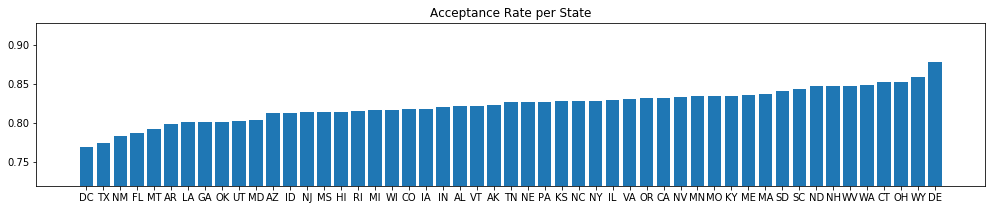

In [36]:
fig, ax = plt.subplots(figsize=(17, 3))
plt.bar(list(pct.index), pct)
plt.title('Acceptance Rate per State')
ax.set_ylim([pct.min()-0.05, pct.max()+0.05])

Yes, it does appear that the origin state may have a (small) affect. The bulk of the states have an acceptance rate of 81% to 83%, but there is some skew on the higher and lower ends.

This appears it could be an artifact from population differences, so let's see the counts.

In [37]:
num = dp.sum().sort_values()
#num

(89, 25745)

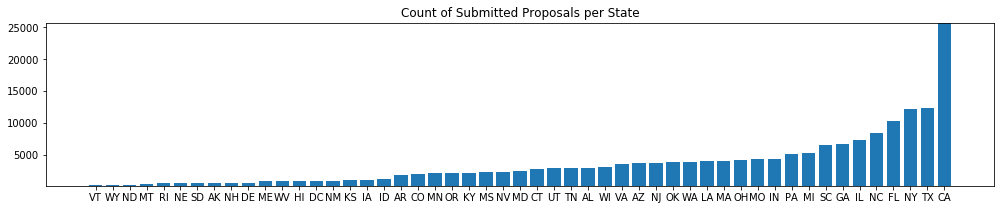

In [38]:
fig, ax = plt.subplots(figsize=(17, 3))
plt.bar(list(num.index), num)
plt.title('Count of Submitted Proposals per State')
ax.set_ylim([num.min()-50, num.max()+50])

Yes, there is a large discrepancy in the number of applications per state. Very interesting, this reduces the significance of the previous conclusion that state origin had an affect. That result may just be an artifact of imbalanced sampling. 

Okay, that's all well and good. Let's see this kind of data for each of the attributes

##FIXME choropleth
##FIXME this plot but normalized and behind the other bar

In [39]:
df['project_submitted_datetime'] = pd.to_datetime(df['project_submitted_datetime'])
df.groupby(df['project_submitted_datetime'].dt.year).sum()

,total
project_submitted_datetime,
2016,7.372773e+07
2017,2.564224e+07


## Encode variables

Pandas is fully capable of doing label encoding and one-hot encoding, there is no need here to use the scikit-learn methods for this. To start, categorical variables are encoded to integers

In [40]:
def categorical_to_int(series):
    return series.astype('category').cat.codes

df.apply(categorical_to_int)

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,total
0,25578,29315,3,33,113097,3,24,321,133693,52228,36978,-1,-1,11869,179,1,76006
1,27694,91061,2,10,179096,0,42,392,75471,108379,169951,-1,-1,120270,1,0,39474
2,163739,69247,3,44,130298,0,36,17,85451,17445,165863,-1,-1,153361,346,1,47967
3,129771,33451,1,27,47535,0,8,293,161090,88865,140054,-1,-1,74811,68,0,62916
4,9632,67811,1,4,40964,1,8,293,153420,75662,23554,-1,-1,59211,322,1,64830
5,44377,25993,2,8,106432,3,3,45,100189,63143,41643,-1,-1,150517,0,1,66265
6,72412,31702,2,24,65187,3,8,293,6692,49812,174475,-1,-1,146272,1,1,41139
7,127271,81048,2,40,37288,3,3,161,45790,15265,22405,-1,-1,176789,0,1,41219
8,80606,73923,3,15,79226,1,32,346,157384,68076,40054,-1,-1,141094,35,1,28920
9,134061,13146,2,14,85878,3,24,321,127474,37582,144717,-1,-1,4557,24,1,3458


# Preprocessing
To use scikit-learn, the values must be continous numbers. Much of the input data is categorical variables, which poses a problem. This can be solved by encoding the categorical variables as integers, and then creating one-hot representations of each class. In this case, pandas has a get_dummies method which creates a one-hot representation directly from the categorical variable. 


In [41]:
from sklearn import tree
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [42]:
# Grab the relevant features, and put the labels in a separate table
features = df[['teacher_prefix',
               'school_state',
               'project_grade_category',
               'project_subject_categories',
               'project_subject_subcategories',
               'teacher_number_of_previously_posted_projects',
               'total']]
labels = df['project_is_approved']

# Clever trick from Pandas to avoid the LabelEncoder -> OneHotEncoder across relevant columns workflow
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
one_hot = pd.get_dummies(features.iloc[:,:5], drop_first=True)
one_hot.head()

,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,teacher_prefix_Teacher,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,...,"project_subject_subcategories_Social Sciences, Visual Arts",project_subject_subcategories_Special Needs,"project_subject_subcategories_Special Needs, Team Sports","project_subject_subcategories_Special Needs, Visual Arts","project_subject_subcategories_Special Needs, Warmth, Care & Hunger",project_subject_subcategories_Team Sports,"project_subject_subcategories_Team Sports, Visual Arts",project_subject_subcategories_Visual Arts,"project_subject_subcategories_Visual Arts, Warmth, Care & Hunger","project_subject_subcategories_Warmth, Care & Hunger"
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Concat one hot representation with continuous attributes

In [43]:
df_train = pd.concat([one_hot, features.iloc[:,-2:]], axis=1)
df_train.head()

,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,teacher_prefix_Teacher,school_state_AL,school_state_AR,school_state_AZ,school_state_CA,school_state_CO,school_state_CT,...,"project_subject_subcategories_Special Needs, Team Sports","project_subject_subcategories_Special Needs, Visual Arts","project_subject_subcategories_Special Needs, Warmth, Care & Hunger",project_subject_subcategories_Team Sports,"project_subject_subcategories_Team Sports, Visual Arts",project_subject_subcategories_Visual Arts,"project_subject_subcategories_Visual Arts, Warmth, Care & Hunger","project_subject_subcategories_Warmth, Care & Hunger",teacher_number_of_previously_posted_projects,total
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,26,899.94
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,400.00
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,469.99
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,684.47
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,42,711.00


## Test some models with k-fold cross validation

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

names = [#'Nearest Neighbors',
         #'Gaussian Process',
         'Decision Tree',
         'Random Forest',
         'Neural Net',
         #'Naive Bayes'
        ]
classifiers = [#KNeighborsClassifier(3),
               #GaussianProcessClassifier(1.0 * RBF(1.0)),
               DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10),
               MLPClassifier(alpha=1),
               #GaussianNB()
              ]

kfold = model_selection.KFold(n_splits=5, random_state=1138)

In [45]:
for name, clf in zip(names, classifiers):
    out = model_selection.cross_val_score(clf, df_train, labels, cv=kfold)
    print('{} ACC: {:0.3f}%  STD: {:0.3f}%'.format(name, out.mean()*100.0, out.std()*100.0))

Decision Tree ACC: 84.754%  STD: 0.128%
Random Forest ACC: 84.768%  STD: 0.131%
Neural Net ACC: 84.768%  STD: 0.131%


## NLP Approach
First steps will be to clean up the essays by removing stop words, punctuation, stemming, lowercasing, etc. Then various methods will be applied to classify the text alone.